## An attempt at BERT

In [13]:
from pathlib import Path
# Install specific libraries
import numpy as np
from itertools import product
from collections import defaultdict

from tqdm import tqdm
tqdm.pandas()

import pandas as pd
pd.options.future.infer_string = True

#Hugging Face Models
import transformers
from transformers import AutoModel, BertTokenizerFast

import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
# specify GPU
device = torch.device("cuda")

# Inspiration from ChatGPT
def get_tuple_combinations(list1, list2):
    combinations = [(item1, item2) for item1, item2 in product(list1, list2) if item1 != item2 and item1 < item2]
    return combinations

# Set path to data folder
DATA_DIR = Path(r"C:\Users\jakob\Desktop\UniStuff\02807_CompTools_Project\data")

In [20]:
# Load social content data - i.e. user and news "interactions" 
newsId = pd.read_csv(DATA_DIR / 'raw/FakeNewsNet/BuzzFeedNews.txt', sep='\t', header=None)
userId = pd.read_csv(DATA_DIR / 'raw/FakeNewsNet/BuzzFeedUser.txt', sep='\t', header=None)

# Create index mappings
idx2newsId = {i+1: key for i, key in enumerate(newsId[0])}
idx2userId = {i+1: key for i, key in enumerate(userId[0])}

# Add real user and news ids/names to dataframe
NewsUser            = pd.read_csv(DATA_DIR / 'raw/FakeNewsNet/BuzzFeedNewsUser.txt', sep='\t', header=None).rename(columns={0: 'newsIndex', 1: 'userIndex', 2: 'n_shares'})
NewsUser['newsId']  = NewsUser['newsIndex'].map(idx2newsId) 
NewsUser['userId']  = NewsUser['userIndex'].map(idx2userId)

# Load content of news data
fake_news       = pd.read_csv(DATA_DIR / 'raw/FakeNewsNet/BuzzFeed_fake_news_content.csv', engine="pyarrow")
real_news       = pd.read_csv(DATA_DIR / 'raw/FakeNewsNet/BuzzFeed_real_news_content.csv', engine="pyarrow")
fake_news['Target'] = ['Fake']*len(fake_news) 
real_news['Target'] = ['True']*len(real_news)
df              = pd.concat([real_news, fake_news]).reset_index(drop=True)
df['news_id']   = newsId
#df.to_csv(DATA_DIR / 'processed/FakeNewsNet/BuzzFeedNewsContent.csv', index=False)

df = df.sample(frac = 1).reset_index().drop(columns='index') # Shuffle the data after concat
df['label'] = pd.get_dummies(df.Target)['Fake'] # BERT model needs 'False' so just renaming... Can probably do it more cleanly
df

,id,title,text,url,top_img,authors,source,publish_date,movies,images,canonical_link,meta_data,Target,news_id,label
0,Real_7-Webpage,Donald Trump's rise puts Ted Cruz in a bind,Story highlights Ted Cruz refused to endorse T...,http://cnn.it/2dlbk5X,http://i2.cdn.cnn.com/cnnnext/dam/assets/16012...,"Manu Raju,Senior Political Reporter",http://cnn.it,NaN,NaN,http://i2.cdn.cnn.com/cnnnext/dam/assets/15121...,http://www.cnn.com/2016/09/22/politics/donald-...,"{""description"": ""If Cruz backs Trump now, he'l...",True,BuzzFeed_Real_67,False
1,Real_3-Webpage,"Critical counties: Wake County, NC, could put ...",Critical Counties is a CNN series exploring 11...,http://cnn.it/2dnoYpa,http://i2.cdn.cnn.com/cnnnext/dam/assets/16091...,"Joyce Tseng,Eli Watkins",http://cnn.it,NaN,NaN,http://i2.cdn.cnn.com/cnnnext/dam/assets/16091...,http://www.cnn.com/2016/09/23/politics/critica...,"{""pubdate"": ""2016-09-23T16:55:31Z"", ""author"": ...",True,BuzzFeed_Real_23,False
2,Fake_51-Webpage,"Two White Men Doused With Gasoline, Set On FIR...",61.3k SHARES Facebook Twitter Update: Buzzf...,http://freedomdaily.com/white-men-set-on-fire-...,http://freedomdaily.com/wp-content/uploads/201...,NaN,http://freedomdaily.com,{'$date': 1474663910000},NaN,http://1csabj4ddrd61fgqez2e4nss.wpengine.netdn...,http://freedomdaily.com/white-men-set-on-fire-...,"{""googlebot"": ""noimageindex"", ""generator"": ""Po...",Fake,BuzzFeed_Fake_47,True
3,Real_27-Webpage,Rouhani: Iran deal able to weather the election,Rouhani: Iran deal able to weather the electio...,http://politi.co/2da5pR0,http://v.politico.com/images/1155968404/201609...,"Jack Shafer,Yousef Saba",http://politi.co,{'$date': 1474483299000},NaN,http://v.politico.com/images/1155968404/201609...,http://www.politico.com/story/2016/09/iran-dea...,"{""description"": ""Donald Trump has repeatedly c...",True,BuzzFeed_Real_20,False
4,Fake_58-Webpage,Riot Police DID Shoot Unarmed Charlotte Protes...,"7k SHARES SHARE THIS STORY Last night, the ...",http://occupydemocrats.com/2016/09/22/multiple...,http://occupydemocrats.com/wp-content/uploads/...,"Grant Stern,Brett Bose,Natalie Dickinson",http://occupydemocrats.com,{'$date': 1474502400000},NaN,http://occupydemocrats.com/wp-content/uploads/...,http://occupydemocrats.com/2016/09/22/multiple...,"{""generator"": ""Powered by Visual Composer - dr...",Fake,BuzzFeed_Fake_54,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,Fake_17-Webpage,Is it the Beginning of the End for Hillary Cli...,I can’t wait for “Weekend at Chelsea’s” to hit...,http://eaglerising.com/36912/is-it-the-beginni...,http://eaglerising.com/wp-content/uploads/2016...,"View All Posts,Matt Barber",http://eaglerising.com,{'$date': 1474444240000},NaN,http://constitution.com/wp-content/uploads/201...,http://eaglerising.com/36912/is-it-the-beginni...,"{""description"": ""Am I saying there\u2019s no c...",Fake,BuzzFeed_Fake_9,True
178,Real_83-Webpage,Trump’s puzzling pitch to black voters,CLEVELAND — Donald Trump campaigned Wednesday ...,http://politi.co/2cRQmvU,http://static.politico.com/f8/4f/00fe12244f809...,"Jack Shafer,Louis Nelson,Matthew Nussbaum,Shan...",http://politi.co,{'$date': 1474460641000},NaN,http://static.politico.com/f8/4f/00fe12244f809...,http://www.politico.com/story/2016/09/is-trump...,"{""description"": ""The Republican nominee brough...",True,BuzzFeed_Real_82,False
179,Fake_13-Webpage,Website is Down For Maintenance,Website is Down For Maintenance,http://www.proudcons.com/clinton-foundation-ca...,NaN,NaN,http://www.proudcons.com,NaN,NaN,NaN,NaN,"{""og"": {""url"": ""http://www.proudcons.com"", ""ty...",Fake,BuzzFeed_Fake_5,True
180,Fake_26-Webpage,Clemson BANS Memes Featuring Dead Gorilla Hara...,Clemson University freshmen may no longer publ...,http://eaglerising.com/37061/clemson-bans-meme...,http://eaglerising.com/wp-content/uploads/2016...,"Campus Reform,View All Posts",http://eaglerising.com,{'$date': 1474871438000},NaN,http://2lv0hm3wvpix464wwy2zh7d1.wpengine.netdn..

In [21]:
# 70:15:15 train/val/test
# Using the TITLE of the article to train the model... 
# Can probably use text instead..
train_text, temp_text, train_labels, temp_labels = train_test_split(df['title'], df['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['Target'])
# Validation-Test split
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

c:\Users\jakob\anaconda3\envs\.venv\Lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jakob\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Text(0, 0.5, 'Number of texts')

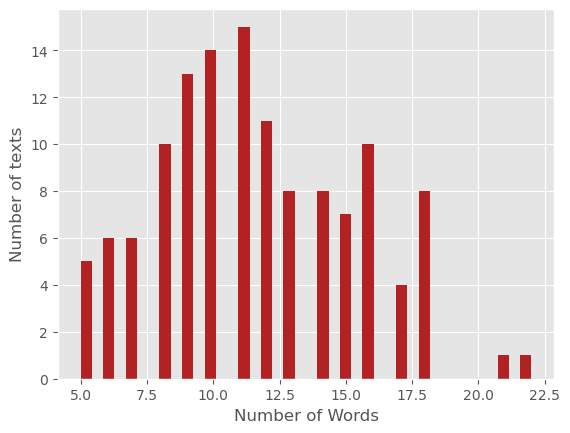

In [22]:
BERT = AutoModel.from_pretrained('bert-base-uncased') #110 million parameters
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Plot histogram of the number of words in train data 'title'
seq_len = [len(title.split()) for title in train_text]
pd.Series(seq_len).hist(bins = 40,color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')